## Hard Constraint

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import deepxde as dde
from utils.gs_solovev_sol import GS_Linear

A = -0.155
eps = 0.32
kappa = 1.7
delta = 0.33

N1 = - (1 + np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N2 = (1 - np.arcsin(delta)) ** 2 / (eps * kappa ** 2)
N3 = - kappa / (eps * np.cos(np.arcsin(delta)) ** 2)

def gen_traindata(num):
    eps = 0.32
    kappa = 1.7
    delta = 0.33
    N = num
    center, eps, kappa, delta = np.array([[0.0,0.0]]), eps, kappa, delta
    tau = np.linspace(0, 2 * np.pi, N)
    # Define boundary of ellipse
    x_ellipse = np.asarray([1 + eps * np.cos(tau + np.arcsin(delta) * np.sin(tau)), 
                    eps * kappa * np.sin(tau)]).T
    xvals = x_ellipse
    uvals = np.zeros(len(xvals)).reshape(len(xvals), 1)
    return xvals, uvals


def pde_solovev(x, u):
    psi = u[:, 0:1]
    psi_r = dde.grad.jacobian(psi, x, i=0, j=0)
    psi_rr = dde.grad.hessian(psi, x, i=0, j=0)
    psi_zz = dde.grad.hessian(psi, x, i=1, j=1)
    GS = psi_rr - psi_r / x[:, 0:1] + psi_zz - (1 - A) * x[:, 0:1] ** 2 - A
    return GS

def psi_r(x,u):
    return dde.grad.jacobian(u, x, i=0, j=0)
def psi_z(x,u):
    return  dde.grad.jacobian(u, x, i=0, j=1)
def psi_rr(x, u):
    return dde.grad.hessian(u, x, i=0, j=0)
def psi_zz(x, u):
    return dde.grad.hessian(u, x, i=1, j=1)

spatial_domain = dde.geometry.Ellipse(eps, kappa, delta) 
n_test = 100
npts = 1000
bc_dirichlet = dde.DirichletBC(spatial_domain, lambda x: 0, lambda _, on_boundary: on_boundary)

data = dde.data.PDE(
    spatial_domain,
    pde_solovev,
    bc_dirichlet,
    num_domain=npts,
    num_boundary=npts,
    num_test=n_test,
    train_distribution="LHS"
)

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
######################
#  Hard Constraints  #
######################

alpha = np.arcsin(delta)
### Notice we are making sure tf.acos() only receives arguments between [-1, 1] to avoid NaNs
def g_xy(x, y):
    return y - eps * kappa * tf.sin(tf.acos(tf.minimum(tf.maximum((x - 1) / eps, -1.0), 1.0)) - alpha * y / eps / kappa)
#     return y - eps * kappa * tf.sin(tf.acos((x - 1) / eps) - alpha * y / eps / kappa)

def g(x):
    x_coord = x[:, 0:1]
    y_coord = x[:, 1:2]
    return g_xy(x_coord, y_coord) * g_xy(x_coord, -y_coord)

def modify_output(x, y):
    return g(x) * y

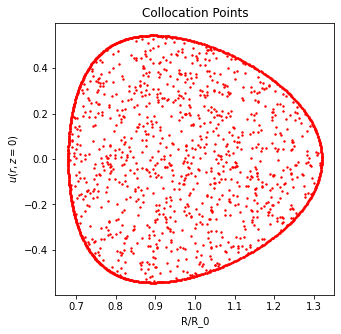

In [3]:
# Plot collocation points for visual check
fig,ax=plt.subplots(1, figsize=(5, 5))
ax.scatter(data.train_x[:, 0], data.train_x[:, 1], s=2, color='r')
ax.set_title('Collocation Points')
ax.set_xlabel('R/R_0')
ax.set_ylabel(r'$u(r,z=0)$')
plt.show()

## Train Model

Compiling model...
Building feed-forward neural network...
'build' took 0.154625 s



/Users/alankaptanoglu/deepxde_copy/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'compile' took 15.328971 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [6.48e-01, 2.74e-18]    [5.54e-01, 2.74e-18]    []  
1         [2.30e-01, 1.26e-17]    [1.69e-01, 1.26e-17]    []  
2         [6.63e-02, 2.89e-17]    [2.67e-02, 2.89e-17]    []  
3         [1.09e-01, 4.76e-17]    [7.83e-02, 4.76e-17]    []  
4         [2.02e-01, 5.98e-17]    [1.73e-01, 5.98e-17]    []  
5         [2.19e-01, 6.15e-17]    [1.90e-01, 6.15e-17]    []  
6         [1.67e-01, 5.57e-17]    [1.39e-01, 5.57e-17]    []  
7         [9.92e-02, 4.66e-17]    [7.16e-02, 4.66e-17]    []  
8         [5.18e-02, 3.70e-17]    [2.53e-02, 3.70e-17]    []  
9         [4.06e-02, 2.88e-17]    [1.39e-02, 2.88e-17]    []  
10        [5.71e-02, 2.28e-17]    [2.99e-02, 2.28e-17]    []  
11        [8.18e-02, 1.91e-17]    [5.41e-02, 1.91e-17]    []  
12        [9.64e-02, 1.75e-17]    [6.89e-02, 1.75e-17]    []  
13        [9.31e-02, 1.77e-17]    [6.6

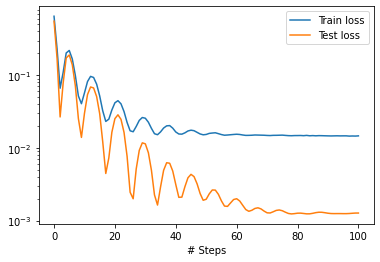

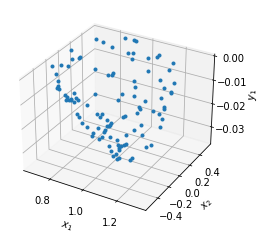

Accuracy
Mean residual: nan


In [4]:
DATE = "10272022"
CONFIG = "ITER_Hard"
LR = 2e-3
DEPTH = 3
BREADTH = 40
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN(
    [2] + DEPTH * [BREADTH] + [1], 
    AF, "Glorot normal")

net.apply_output_transform(modify_output)

model = dde.Model(data, net)

decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,1], 
  )
  loss_history, train_state = model.train(epochs=100, display_every=1)
  dde.saveplot(
      loss_history,
      train_state, 
      issave=True, 
      isplot=True,
      output_dir=PATH
  )

# make mesh
nx = 100
ny = 100
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom
x, y = np.meshgrid(
    np.linspace(innerPoint, outerPoint, nx),
    np.linspace(lowPoint, highPoint, ny),
)
X = np.vstack((np.ravel(x), np.ravel(y))).T
output = model.predict(X)
GS = model.predict(X, operator=pde_solovev)
residual_psi = np.mean(np.absolute(GS))

print("Accuracy")
print("Mean residual:", residual_psi)

[[0.04848738 0.03268813 0.0203071  ... 1.02417157 1.70126358 2.60227775]
 [0.05620897 0.03822331 0.02400179 ... 0.98062878 1.62629909 2.48547658]
 [0.06410177 0.04387854 0.02777153 ... 0.93808881 1.55376477 2.37313724]
 ...
 [0.05912431 0.039978   0.02484341 ... 1.01207521 1.65177598 2.49779946]
 [0.05090122 0.03408013 0.02090686 ... 1.06650397 1.74009944 2.63024133]
 [0.04290755 0.02835507 0.01709216 ... 1.12327895 1.83266471 2.76947668]]
[[0.04848738 0.03268813 0.0203071  ... 1.02417157 1.70126358 2.60227775]
 [0.05620897 0.03822331 0.02400179 ... 0.98062878 1.62629909 2.48547658]
 [0.06410177 0.04387854 0.02777153 ... 0.93808881 1.55376477 2.37313724]
 ...
 [0.05912431 0.039978   0.02484341 ... 1.01207521 1.65177598 2.49779946]
 [0.05090122 0.03408013 0.02090686 ... 1.06650397 1.74009944 2.63024133]
 [0.04290755 0.02835507 0.01709216 ... 1.12327895 1.83266471 2.76947668]]


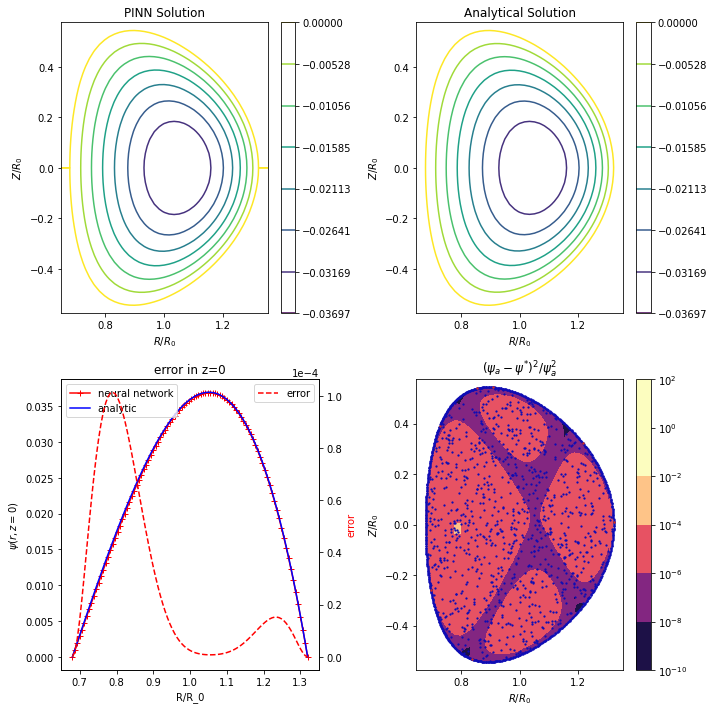

In [5]:
from utils.utils import *
ITER = GS_Linear(eps=0.32, kappa=1.7, delta=0.33)
ITER.get_BCs(A)
ITER.solve_coefficients()
X_test = spatial_domain.random_points(333)
plot_summary_figure(ITER, model, X_test, PATH)

#### After BFGS

Compiling model...
'compile' took 12.710959 s

Training model...

Step      Train loss              Test loss               Test metric
100       [1.46e-02, 3.26e-17]    [1.27e-03, 3.26e-17]    []  
110       [1.46e-02, 3.28e-17]    [1.46e-02, 3.28e-17]        
120       [1.46e-02, 3.28e-17]    [1.46e-02, 3.28e-17]        
130       [1.44e-02, 3.28e-17]    [1.44e-02, 3.28e-17]        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.014438
  Number of iterations: 5
  Number of functions evaluations: 38
138       [1.44e-02, 3.28e-17]    [1.21e-03, 3.28e-17]    []  

Best model at step 138:
  train loss: 1.44e-02
  test loss: 1.21e-03
  test metric: []

'train' took 12.510182 s

Saving loss history to ./cefron/ITER_Hard/runs/network_sweep_10272022_depth03_breadth40_swish_lr0.002-varying-short_lw1-10_01_100Adam_BFGS/loss.dat ...
Saving training data to ./cefron/ITER_Hard/runs/network_sweep_10272022_depth

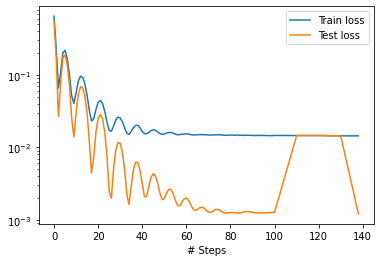

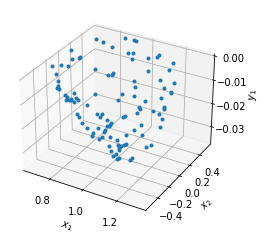

In [6]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1, 1]
)
loss_history, train_state = model.train(epochs=1000, display_every=10)
dde.saveplot(
    loss_history, 
    train_state, 
    issave=True, 
    isplot=True,
    output_dir=PATH
)


[[0.04705627 0.03151595 0.0193863  ... 0.99876548 1.66844497 2.56161323]
 [0.05479184 0.03705729 0.02308043 ... 0.9576871  1.59668725 2.44880414]
 [0.06271489 0.04273336 0.02686273 ... 0.91745202 1.52715085 2.34018702]
 ...
 [0.05780985 0.03889896 0.02399472 ... 0.9905931  1.62427132 2.46390839]
 [0.0495712  0.03299395 0.02005842 ... 1.04252283 1.70939483 2.59241737]
 [0.04158077 0.02727897 0.01625936 ... 1.09660874 1.79851512 2.7274119 ]]
[[0.04705627 0.03151595 0.0193863  ... 0.99876548 1.66844497 2.56161323]
 [0.05479184 0.03705729 0.02308043 ... 0.9576871  1.59668725 2.44880414]
 [0.06271489 0.04273336 0.02686273 ... 0.91745202 1.52715085 2.34018702]
 ...
 [0.05780985 0.03889896 0.02399472 ... 0.9905931  1.62427132 2.46390839]
 [0.0495712  0.03299395 0.02005842 ... 1.04252283 1.70939483 2.59241737]
 [0.04158077 0.02727897 0.01625936 ... 1.09660874 1.79851512 2.7274119 ]]


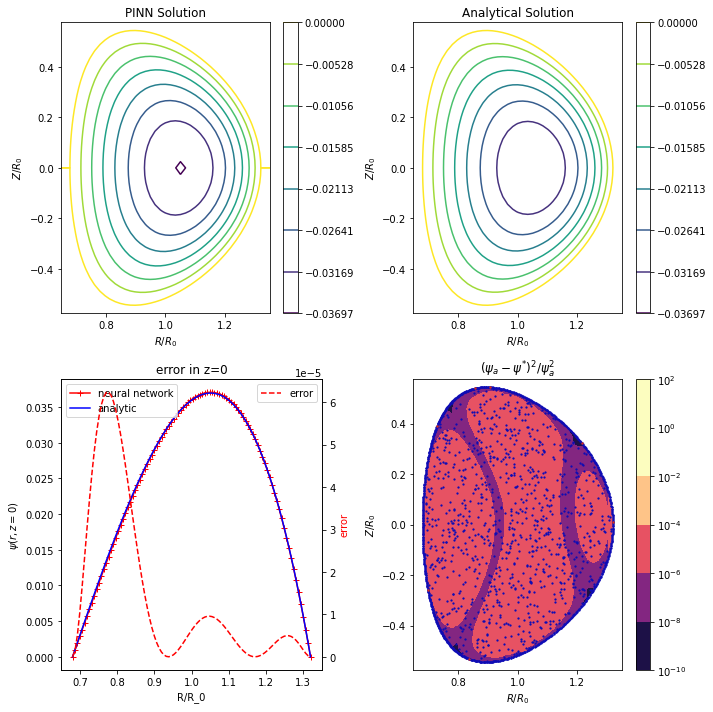

In [7]:
plot_summary_figure(ITER, model, X_test, PATH)

### Retrain WITHOUT hard boundary for direct comparison

Compiling model...
Building feed-forward neural network...
'build' took 0.107297 s



/Users/alankaptanoglu/deepxde_copy/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'compile' took 3.917166 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.06e+00, 2.92e-01]    [9.58e-01, 2.92e-01]    []  
1         [1.47e+00, 1.14e+01]    [1.37e+00, 1.14e+01]    []  
2         [1.16e+00, 4.54e-01]    [1.06e+00, 4.54e-01]    []  
3         [1.02e+00, 6.64e-01]    [9.17e-01, 6.64e-01]    []  
4         [1.00e+00, 1.15e+00]    [9.04e-01, 1.15e+00]    []  
5         [1.08e+00, 2.68e-01]    [9.78e-01, 2.68e-01]    []  
6         [1.19e+00, 3.23e-01]    [1.10e+00, 3.23e-01]    []  
7         [1.26e+00, 7.63e-01]    [1.16e+00, 7.63e-01]    []  
8         [1.24e+00, 2.49e-01]    [1.15e+00, 2.49e-01]    []  
9         [1.20e+00, 3.42e-02]    [1.10e+00, 3.42e-02]    []  
10        [1.16e+00, 3.33e-01]    [1.06e+00, 3.33e-01]    []  
11        [1.13e+00, 5.14e-01]    [1.03e+00, 5.14e-01]    []  
12        [1.11e+00, 3.65e-01]    [1.01e+00, 3.65e-01]    []  
13        [1.10e+00, 1.15e-01]    [1.00

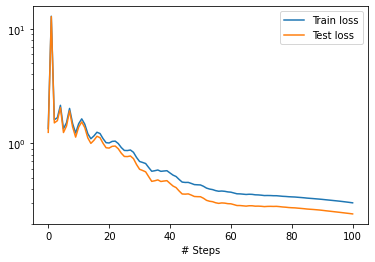

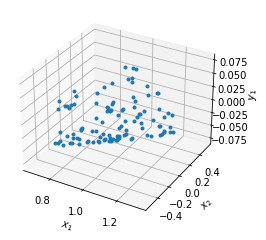

Accuracy
Mean residual: 0.3785501


In [8]:
DATE = "10272022"
CONFIG = "ITER_Hard"
LR = 2e-2
DEPTH = 3
BREADTH = 40
run = "01_100Adam_BFGS"
AF = "swish"
RUN_NAME = f"network_sweep_{DATE}_depth0{DEPTH}_breadth{BREADTH}_{AF}_lr{LR}-varying-short_lw1-10_{run}"

PATH = f"./cefron/{CONFIG}/runs/{RUN_NAME}"
# Check whether the specified path exists or not
isExist = os.path.exists(PATH)
if not isExist:
  # Create a new directory because it does not exist 
  os.makedirs(PATH)
  print("The new directory is created!")

net = dde.maps.FNN(
    [2] + DEPTH * [BREADTH] + [1], 
    AF, "Glorot normal")

model = dde.Model(data, net)

decay_rate = 1.0
for i in range(1):
  # Compile, train and save model
  model.compile(
      "adam", lr=LR/(decay_rate*(i+1)),
      loss_weights=[1,100], 
  )
  loss_history, train_state = model.train(epochs=100, display_every=1)
  dde.saveplot(
      loss_history,
      train_state, 
      issave=True, 
      isplot=True,
      output_dir=PATH
  )

# make mesh
nx = 100
ny = 100
zoom = ((1 + eps)-(1 - eps))*0.05
innerPoint = 1 - eps - zoom
outerPoint = 1 + eps + zoom
lowPoint   = -kappa * eps - zoom
highPoint  = kappa * eps + zoom
x, y = np.meshgrid(
    np.linspace(innerPoint, outerPoint, nx),
    np.linspace(lowPoint, highPoint, ny),
)
X = np.vstack((np.ravel(x), np.ravel(y))).T
output = model.predict(X)
GS = model.predict(X, operator=pde_solovev)
residual_psi = np.mean(np.absolute(GS))

print("Accuracy")
print("Mean residual:", residual_psi)

[[ 2.59226029  3.11722115  3.69219312 ... 26.29748909 24.92009199
  23.43715613]
 [ 1.42548235  1.81650821  2.25642171 ... 22.85710297 21.62947827
  20.30515792]
 [ 0.63904164  0.90545892  1.21949361 ... 19.7648346  18.67198576
  17.49092256]
 ...
 [ 2.33445191  2.40707818  2.47915433 ...  5.31690928  6.83758045
   8.63935423]
 [ 3.56174805  3.63459271  3.70569809 ...  5.45595487  7.06459282
   8.97409543]
 [ 5.10900658  5.17597739  5.23986617 ...  5.57432596  7.27165388
   9.29079179]]
[[ 2.59226029  3.11722115  3.69219312 ... 26.29748909 24.92009199
  23.43715613]
 [ 1.42548235  1.81650821  2.25642171 ... 22.85710297 21.62947827
  20.30515792]
 [ 0.63904164  0.90545892  1.21949361 ... 19.7648346  18.67198576
  17.49092256]
 ...
 [ 2.33445191  2.40707818  2.47915433 ...  5.31690928  6.83758045
   8.63935423]
 [ 3.56174805  3.63459271  3.70569809 ...  5.45595487  7.06459282
   8.97409543]
 [ 5.10900658  5.17597739  5.23986617 ...  5.57432596  7.27165388
   9.29079179]]


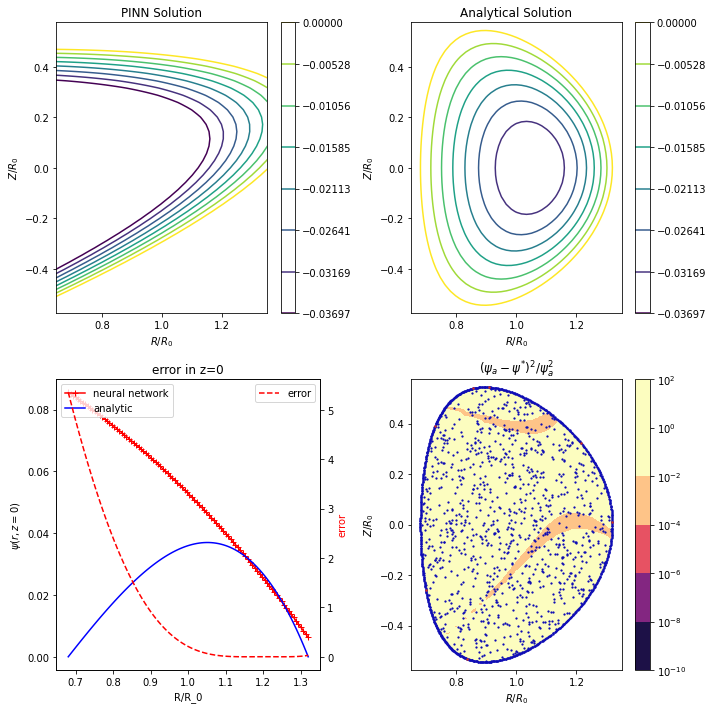

In [9]:
plot_summary_figure(ITER, model, X_test, PATH)

Compiling model...
'compile' took 4.268014 s

Training model...

Step      Train loss              Test loss               Test metric
100       [1.70e-01, 1.34e+00]    [1.09e-01, 1.34e+00]    []  
110       [5.52e-01, 2.34e-01]    [5.52e-01, 2.34e-01]        
120       [2.30e-01, 5.12e-01]    [2.30e-01, 5.12e-01]        
130       [1.84e-01, 1.67e-01]    [1.84e-01, 1.67e-01]        
140       [3.96e-02, 1.24e-01]    [3.96e-02, 1.24e-01]        
150       [2.80e-02, 6.76e-03]    [2.80e-02, 6.76e-03]        
160       [2.76e-03, 8.34e-03]    [2.76e-03, 8.34e-03]        
170       [1.42e-03, 3.36e-03]    [1.42e-03, 3.36e-03]        
180       [1.49e-03, 2.28e-03]    [1.49e-03, 2.28e-03]        
190       [5.68e-04, 4.04e-03]    [5.68e-04, 4.04e-03]        
200       [4.07e-04, 7.49e-04]    [4.07e-04, 7.49e-04]        
210       [4.01e-04, 6.00e-04]    [4.01e-04, 6.00e-04]        
220       [3.04e-04, 5.39e-04]    [3.04e-04, 5.39e-04]        
230       [2.77e-04, 2.78e-04]    [2.77e-04, 2

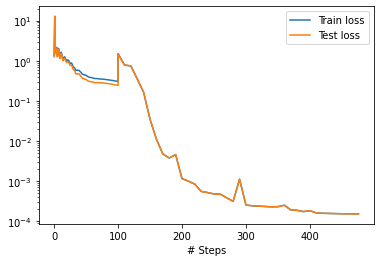

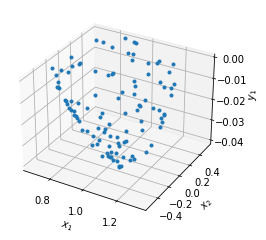

In [10]:
# Compile, train and save model
model.compile(
    "L-BFGS-B",
    loss_weights=[1, 1000]
)
loss_history, train_state = model.train(epochs=1000, display_every=10)
dde.saveplot(
    loss_history, 
    train_state, 
    issave=True, 
    isplot=True,
    output_dir=PATH
)


[[0.55644057 0.5207946  0.48397585 ... 6.96048888 7.55887664 8.18800567]
 [0.45924698 0.42897897 0.39772009 ... 6.19700005 6.71634054 7.26105722]
 [0.37585535 0.35037994 0.32406406 ... 5.48302182 5.93024446 6.39805477]
 ...
 [0.04894625 0.04629637 0.0435275  ... 0.26884671 0.28634255 0.30427312]
 [0.06449272 0.06098547 0.05733516 ... 0.36973002 0.39720473 0.42578944]
 [0.08321853 0.07869859 0.07400953 ... 0.49197657 0.53213757 0.5743419 ]]
[[0.55644057 0.5207946  0.48397585 ... 6.96048888 7.55887664 8.18800567]
 [0.45924698 0.42897897 0.39772009 ... 6.19700005 6.71634054 7.26105722]
 [0.37585535 0.35037994 0.32406406 ... 5.48302182 5.93024446 6.39805477]
 ...
 [0.04894625 0.04629637 0.0435275  ... 0.26884671 0.28634255 0.30427312]
 [0.06449272 0.06098547 0.05733516 ... 0.36973002 0.39720473 0.42578944]
 [0.08321853 0.07869859 0.07400953 ... 0.49197657 0.53213757 0.5743419 ]]


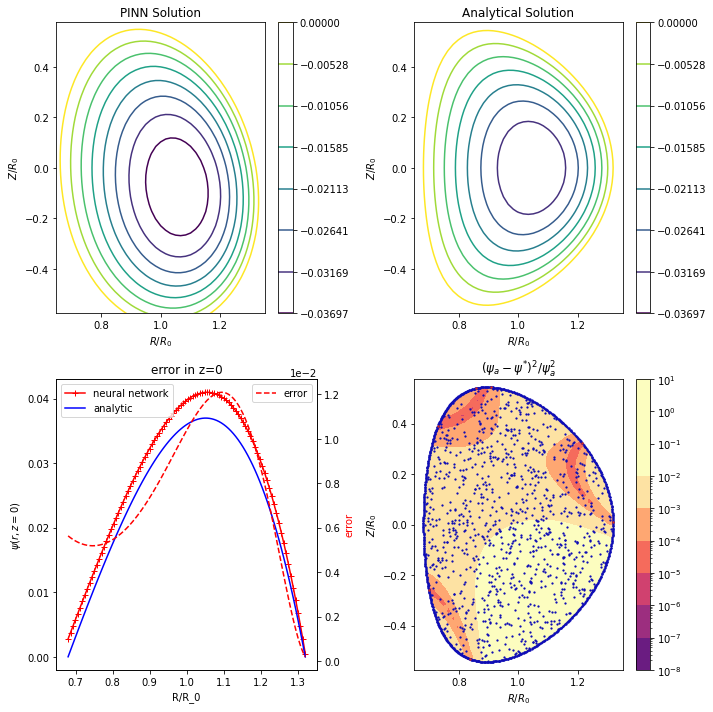

In [11]:
plot_summary_figure(ITER, model, X_test, PATH)